In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Examining Data from CSVs

In [10]:
# Viewing columns for measurement
engine.execute('SELECT * from measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
inspector_m = inspect(engine)
columns_m = inspector_m.get_columns('measurement')
for c in columns_m:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Viewing columns for station
engine.execute('SELECT * from station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [13]:
inspector_s = inspect(engine)
columns_s = inspector_m.get_columns('station')
for x in columns_s:
    print(x['name'], x['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

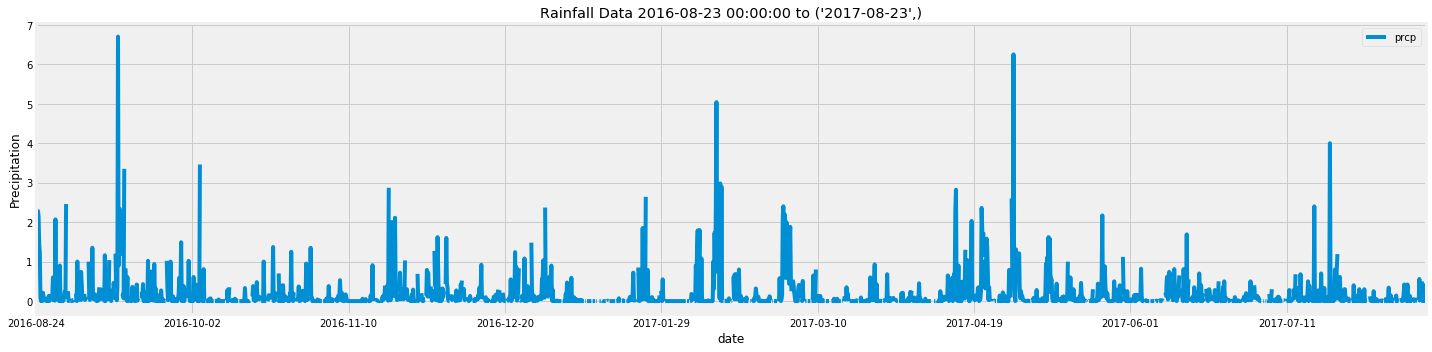

In [14]:
### Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Last day is '2017-08-23', will use place holder for now
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
date = dt.datetime(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
rainfall = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rainfall_db = pd.DataFrame(rainfall)
rainfall_db = rainfall_db.set_index('date')

# Sort the dataframe by date
rainfall_db = rainfall_db.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
rainfall_db.plot(figsize=(20,5),title=f'Rainfall Data {date} to {last_date}')
plt.ylabel('Precipitation')
plt.tight_layout()

![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rainfall_db.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [17]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Most activce station
big_station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).first()[0]
print(f'{big_station_activity} was the station with the most activity')

USC00519281 was the station with the most activity


In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_temp = session.query(Measurement.tobs, func.min(Measurement.tobs)).\
            filter(Measurement.station == big_station_activity).first()
max_temp = session.query(Measurement.tobs, func.max(Measurement.tobs)).\
            filter(Measurement.station == big_station_activity).first()
avg_temp = session.query(Measurement.tobs, func.avg(Measurement.tobs)).\
            filter(Measurement.station == big_station_activity).first()
print(f'The lowest temparature recorded at {big_station_activity} was {min_temp[0]}.')
print(f'The highest temparature recorded at {big_station_activity} was {max_temp[0]}.')
print(f'The average temparature recorded at {big_station_activity} was {avg_temp[0]}.')


The lowest temparature recorded at USC00519281 was 54.0.
The highest temparature recorded at USC00519281 was 85.0.
The average temparature recorded at USC00519281 was 70.0.


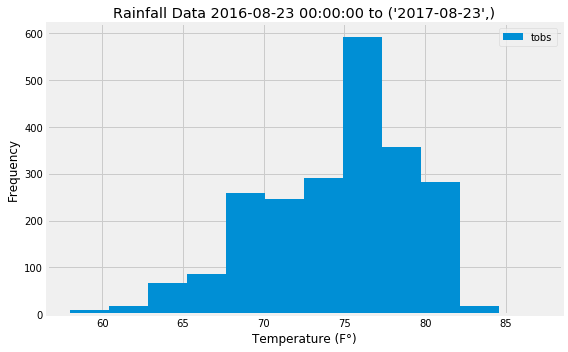

In [56]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > date).all()

temperature_df = pd.DataFrame(temperature)
temperature_df = temperature_df.set_index('date')
temperature_df = temperature_df.sort_index(ascending=True)

temperature_df.plot(kind='hist',bins=12,figsize=(8,5),title=f'Rainfall Data {date} to {last_date}')
plt.xlabel('Temperature (F°)')
plt.tight_layout()


![precipitation](Images/station-histogram.png)

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [58]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-03-12'
trip_end = '2017-03-18'

trip_temps = calc_temps(trip_start,trip_end)
trip_temps

[(65.0, 71.38636363636364, 80.0)]

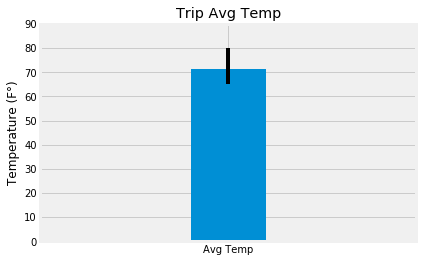

In [72]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temp_min = trip_temps[0][0]
trip_temp_avg = trip_temps[0][1]
trip_temp_max = trip_temps[0][2]

tmin = trip_temp_avg - trip_temp_min
tmax = trip_temp_max - trip_temp_avg

plt.bar('Avg Temp',trip_temp_avg, yerr=[[tmin],[tmax]])
plt.xlim(-2,2)
plt.ylim(0,90)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F°)')
plt.show()

In [92]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = ([Station.station,
       Station.name,
       func.sum(Measurement.prcp),
       Station.latitude,
       Station.longitude,
       Station.elevation])

trip_rainfall = session.query(*sel).\
            filter(Station.station ==  Measurement.station).\
            filter(Measurement.date >= trip_start).\
            filter(Measurement.date <= trip_end).\
            group_by(Station.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()

trip_rainfall

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.35,
  21.33556,
  -157.71139,
  19.5),
 ('USC00513117', 'KANEOHE 838.1, HI US', 0.19, 21.4234, -157.8015, 14.6),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.18,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00517948', 'PEARL CITY, HI US', 0.06, 21.3934, -157.9751, 11.9),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.06,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  0.0,
  21.3331,
  -157.8025,
  152.4)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
